# Target:
- Adding learning rate schedulers for better results.
- To achive the desired accuracy consistantly in atlest 3 epochs

# Results:

- Model Parameters : 7.4k
- Best Training accuracy : 99.24
- Best Training loss : 0.00553
- Best Testing accuracy : 99.56%
- Best Testing loss : 0.0168

# Analysis:
- We tried different learning rate schedulers like **ReduceLRPlatue** which did not work because on platue decreses the learning rate when loss is incresing in a particular epochs but this did not happen in out problem. **StepLR** also did not work because it is hard to predict at which point the learning rate should be reduced.

- So, we have used **OneCycleLR** which updates learning rate throughout the epoch with every single batch is passed (Learning rate is updated in a particular range)

- As we can see the model is underfit in the first epoch but start getting better by the second epoch.

- We can see some ups and downs in the accuracy while training, but in the end we are able to achive the desired result.

- We can see the accuracy of **more than 99.4 in last five epochs (Form 11 to 15)**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

import matplotlib.pyplot as plt # for ploting the results
import numpy as np # for mathematical work

In [ ]:
# For training set
train = datasets.MNIST('../data', train=True, download=True, #create directory and give the path, True for training set, download if dataset is not available in local storage
                    transform=transforms.Compose([
                        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)),# Normalize image with mean and standard deviation
                        transforms.RandomRotation((-5.0, 5.0), fill=(0.1307,)),
                        ])
                    )


# For testing set
test = datasets.MNIST('../data', train=False,  # create the directory for testing dataset, train is false for testing 
                   transform=transforms.Compose([ 
                        transforms.ToTensor(), # Convert image to tensor
                        transforms.Normalize((0.1307,), (0.3081,)) # Normalize the data
                        ])
                   )

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available: True


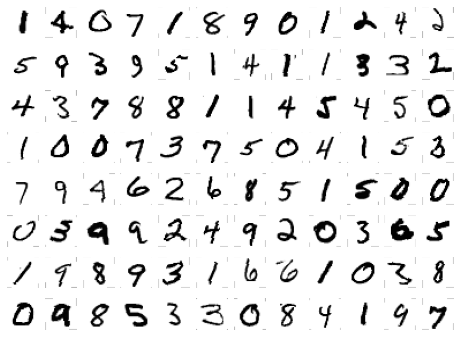

In [ ]:
figure = plt.figure(figsize=(8,6))
dataiter = iter(train_loader)
images, labels = dataiter.next()
num_of_images = 96
for index in range(1, num_of_images + 1):
    plt.subplot(8, 12, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        drop = 0.025  # droput value
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(drop)
        ) # output_size = 26    RF:  2

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop)
        ) # output_size = 24 RF: 5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12    RF:  6

        # TRANSITION BLOCK 1
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 12    RF:  6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # output_size = 10    RF:  10
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # output_size = 8    RF: 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False), # output_size = 6    RF: 18
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(drop)
        ) 
        
        # Global average pooling
        self.gap = nn.Sequential(
            nn.AvgPool2d(6)  # output_size = 1    RF:  28
        )

        # Fully connected layer
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), # output_size = 1    RF: 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),  # output  RF: 28
        )

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.trans1(x)
        x = self.convblock3(x)
        x = self.gap(x)
        x = self.convblock5(x)
        x = x.view(-1, 10)   # convert 2D to 1D
        
        return F.log_softmax(x, dim=-1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]             864
      BatchNorm2d-14           [-1

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch 
    # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop, 
    # ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update LR
    scheduler.step()
    
    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Batch_id={batch_idx} Loss={loss.item():.5f} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model =  Net().to(device)
NUM_EPOCHS = 15
optimizer = optim.SGD(model.parameters(), lr=0.017, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.017, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

for epoch in range(1,NUM_EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2105, Accuracy: 9654/10000 (96.54%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0912, Accuracy: 9739/10000 (97.39%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9879/10000 (98.79%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9840/10000 (98.40%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9912/10000 (99.12%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9901/10000 (99.01%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


Batch_id=468 Loss=0.02282 Accuracy=99.24: 100%|██████████| 469/469 [00:37<00:00, 12.47it/s]



Test set: Average loss: 0.0168, Accuracy: 9956/10000 (99.56%)



Text(0.5, 1.0, 'Test Accuracy')

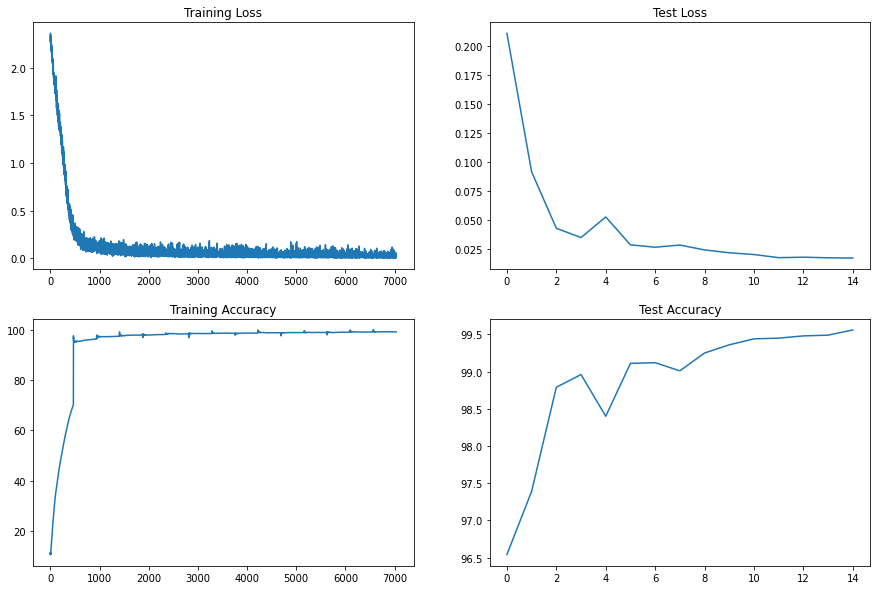

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

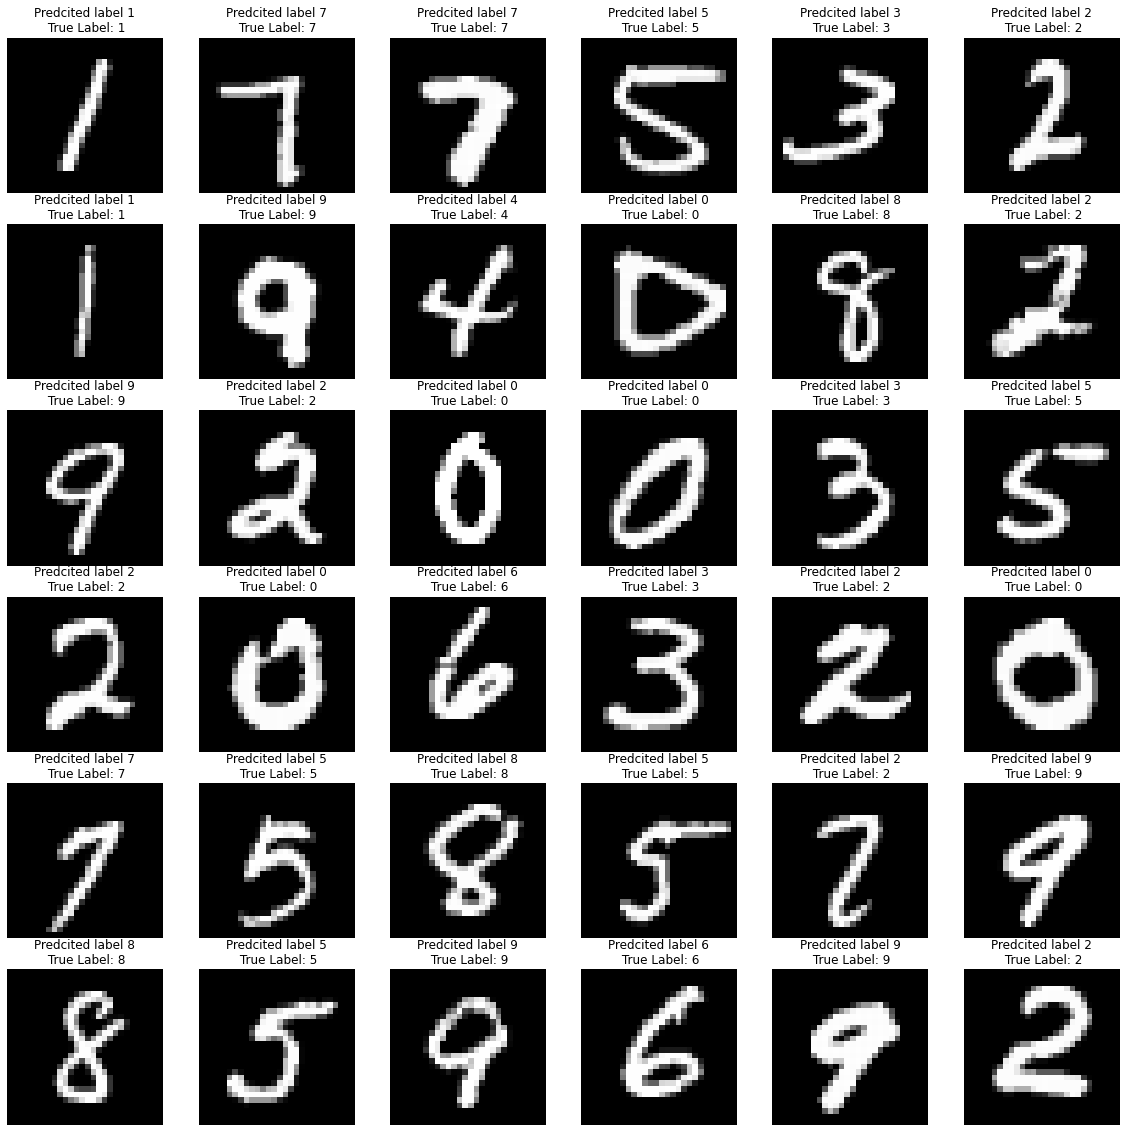

In [ ]:
cols, rows = 6,6
figure = plt.figure(figsize=(20, 20))
for i in range(1, cols * rows + 1):
    k = np.random.randint(0, len(test_loader.dataset)) # random points from test dataset
  
    img, label = test_loader.dataset[k] # separate the image and label
    img = img.unsqueeze(0) # adding one dimention
    pred=  model(img.to(device)) # Prediction 

    figure.add_subplot(rows, cols, i) # adding sub plot
    plt.title(f"Predcited label {pred.argmax().item()}\n True Label: {label}") # title of plot
    plt.axis("off") # hiding the axis
    plt.imshow(img.squeeze(), cmap="gray") # showing the plot

plt.show()